In [85]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from urllib.parse import quote_plus
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import numpy as np

In [2]:
# load environment
load_dotenv()
# export env

src_host = os.getenv('SRC_HOST')
src_port = os.getenv('SRC_PORT')
src_dbname = os.getenv('SRC_DBNAME')
src_user = os.getenv('SRC_USER')
src_password = quote_plus(os.getenv('SRC_PASSWORD'))
src_table = os.getenv('SRC_TABLE')

In [15]:
redshift_url = f"redshift+psycopg2://{src_user}:{src_password}@{src_host}:{src_port}/{src_dbname}?sslmode=disable"

In [18]:
engine = create_engine(redshift_url)
query = f"SELECT * FROM {src_table};"

# use this for pandas > 2.20
with engine.connect() as conn:
    df = pd.read_sql(
        sql=query,
        con=conn.connection
    )

/tmp/ipykernel_69469/2569432139.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [20]:
#to shows all features
pd.set_option('display.max_columns',None)

In [126]:
df[df['track_artist']=="Queen"]

,track_name,track_artist,track_popularity,track_album_name,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,album_release_year,album_release_month
232,Sheer Heart Attack - Remastered 2011,Queen,39,News Of The World (2011 Remaster),The Queen - La Discografia Completa,Rock,Album rock,0.155,0.9380,10,-4.624,1,0.1260,0.00543,0.002620,0.3590,0.383,184.469,207600.0,1977,10
233,"All Dead, All Dead - Remastered 2011",Queen,40,News Of The World (2011 Remaster),The Queen - La Discografia Completa,Rock,Album rock,0.491,0.0765,5,-14.570,1,0.0416,0.78700,0.000306,0.1140,0.305,113.728,189587.0,1977,10
234,Spread Your Wings - 2011 Mix,Queen,59,News Of The World (2011 Remaster),The Queen - La Discografia Completa,Rock,Album rock,0.395,0.6560,9,-6.462,1,0.0329,0.29000,0.000027,0.0624,0.487,174.782,274227.0,1977,10
235,Fight From The Inside - Remastered 2011,Queen,37,News Of The World (2011 Remaster),The Queen - La Discografia Completa,Rock,Album rock,0.577,0.8480,0,-5.673,0,0.0755,0.12500,0.000274,0.6130,0.327,89.967,181627.0,1977,10
236,"Get Down, Make Love - Remastered 2011",Queen,36,News Of The World (2011 Remaster),The Queen - La Discografia Completa,Rock,Album rock,0.446,0.7130,8,-4.825,1,0.2680,0.41000,0.000000,0.2120,0.369,143.229,230120.0,1977,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26734,Don't Stop Me Now - 2011 Mix,Queen,75,Jazz (Deluxe Remastered Version),Dr. Q's Prescription Playlist💊,Pop,Post-teen pop,0.563,0.8650,5,-5.277,1,0.1600,0.04720,0.000191,0.7700,0.601,156.271,209413.0,1978,11
27761,Killer Queen - Remastered 2011,Queen,21,Sheer Heart Attack (2011 Remaster),House Of The Rising Sun,Rock,Album rock,0.535,0.6510,10,-6.326,1,0.0544,0.39100,0.000000,0.1330,0.612,117.218,179600.0,1974,11
28314,We Are The Champions,Queen,0,We Will Rock You,70s Pop & Rock Hits and Deep Tracks,Rock,Album rock,0.281,0.3120,10,-14.576,1,0.0330,0.45000,0.000001,0.0949,0.221,90.143,180800.0,1992,1
30107,Under Pressure,Queen,1,Greatest Hits II,Classic Hard Rock,Rock,Hard rock,0.670,0.5350,2,-12.657,1,0.0523,0.40400,0.000000,0.0858,0.429,113.481,236760.0,1991,10


In [21]:
df.head()

,track_name,track_artist,track_popularity,track_album_name,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,album_release_year,album_release_month
0,Alone,Alan Walker,70,Alone,Electropop Hits 2017-2020,Pop,Electropop,0.676,0.929,10,-3.194,1,0.0458,0.1860,0.000405,0.1210,0.157,97.019,161200.0,2016,12
1,Speechless (feat. Erika Sirola),Robin Schulz,78,Speechless (feat. Erika Sirola),Electropop 2019,Pop,Electropop,0.574,0.728,1,-4.777,1,0.0620,0.0161,0.000001,0.0851,0.266,125.047,214942.0,2018,11
2,Instant Crush,Daft Punk,75,Random Access Memories,ELECTROPOP,Pop,Electropop,0.775,0.585,10,-9.516,0,0.0271,0.0422,0.619000,0.0770,0.518,109.942,337560.0,2013,5
3,Wait,Maroon 5,7,Red Pill Blues (Deluxe),Electropop Hits 2017-2020,Pop,Electropop,0.659,0.604,8,-5.084,1,0.0542,0.0889,0.000000,0.1050,0.407,126.135,190643.0,2017,11
4,Money For Nothing - Edit,Dire Straits,5,Sultans Of Swing - The Very Best Of Dire Straits,Hard Rock Cafe Classics,Rock,Hard rock,0.679,0.676,2,-9.734,0,0.0371,0.0777,0.000014,0.0938,0.800,134.238,246840.0,1998,11


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32821 entries, 0 to 32820
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_name           32821 non-null  object 
 1   track_artist         32821 non-null  object 
 2   track_popularity     32821 non-null  int64  
 3   track_album_name     32821 non-null  object 
 4   playlist_name        32821 non-null  object 
 5   playlist_genre       32821 non-null  object 
 6   playlist_subgenre    32821 non-null  object 
 7   danceability         32821 non-null  float64
 8   energy               32821 non-null  float64
 9   key                  32821 non-null  int64  
 10  loudness             32821 non-null  float64
 11  mode                 32821 non-null  int64  
 12  speechiness          32821 non-null  float64
 13  acousticness         32821 non-null  float64
 14  instrumentalness     32821 non-null  float64
 15  liveness             32821 non-null 

## Prepare Features

In [24]:
features = features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

In [25]:
scaler =  MinMaxScaler()
normalized_features = scaler.fit_transform(df[features])

In [28]:
print(normalized_features)

[[0.68769074 0.92898757 0.90909091 ... 0.15842583 0.40519128 0.30594967]
 [0.58392675 0.72795239 0.09090909 ... 0.26841574 0.52224774 0.41054475]
 [0.78840285 0.58492736 0.90909091 ... 0.52270434 0.45916305 0.64918939]
 ...
 [0.61139369 0.98999825 0.54545455 ... 0.19374369 0.53440528 0.28050252]
 [0.85045778 0.92598705 0.18181818 ... 0.1493441  0.53448463 0.47353886]
 [0.85757884 0.8439727  0.18181818 ... 0.73360242 0.53449716 0.54689477]]


## Calculation using cosine-similarity

In [29]:
similarity_matrix = cosine_similarity(normalized_features)

MemoryError: Unable to allocate 8.03 GiB for an array with shape (32821, 32821) and data type float64

## Calculation using annoy

since using cosine_similarity occured this error "MemoryError: Unable to allocate 8.03 GiB for an array with shape (32821, 32821) and data type float64"

In [31]:
# Set parameters
n_trees = 10
n_neighbors = 10

# Annoy Index
feature_length = normalized_features.shape[1]
annoy_index = AnnoyIndex(feature_length, 'angular')

In [32]:
# building annoy_index

for i, feature_vector in enumerate(normalized_features):
    annoy_index.add_item(i,feature_vector)

annoy_index.build(n_trees)

True

In [107]:
def recommend_tracks_annoy(track_name, track_artist, df, annoy_index, top_n=10):
    try:
        track_index = df[(df['track_name'] == track_name) & (df['track_artist'] == track_artist)].index[0]
        neighbor_indices = annoy_index.get_nns_by_item(track_index, top_n + 2)  # +1 to exclude the track itself
        neighbor_indices = neighbor_indices[2:]  # Exclude the track itself
        recommendations = df.iloc[neighbor_indices][['track_name', 'track_artist']]
        return recommendations
    except IndexError:
        return "Track not found in the dataset."

In [121]:
def recommend_tracks_annoy(track_name, track_artist, df, annoy_index, top_n=10):
    try:
        track_index = df[(df['track_name'] == track_name) & (df['track_artist'] == track_artist)].index[0]
        neighbor_indices = annoy_index.get_nns_by_item(track_index, top_n + 2)  # +1 to exclude the track itself
        neighbor_indices = neighbor_indices[2:]  # Exclude the track itself
        recommendations = df.iloc[neighbor_indices][['track_name', 'track_artist', 'danceability', 'energy', 'liveness']]
        return recommendations
    except IndexError:
        return "Track not found in the dataset."

In [127]:
track_name = "We Are The Champions"
track_artist = "Queen"
recommended_tracks = recommend_tracks_annoy(track_name, track_artist, df, annoy_index)
print(recommended_tracks)

                                   track_name      track_artist  danceability  \
23522                          Cuts Both Ways    Gloria Estefan         0.380   
18232                                  Closer            JYWRRN         0.414   
20997                         Wrong Direction  Hailee Steinfeld         0.378   
5907                                Walk Away              LANY         0.323   
21749      Burning House (feat. Aaron Krause)               EZA         0.445   
11337  We Are The Champions - Remastered 2011             Queen         0.268   
11810  We Are The Champions - Remastered 2011             Queen         0.268   
24583                                    Heat       David Bowie         0.373   
14816                      Quando Fuori Piove            Ultimo         0.411   
25204                         Humble And Kind        Tim McGraw         0.355   

       energy  liveness  
23522   0.309    0.0733  
18232   0.323    0.0946  
20997   0.388    0.1570  
5907

In [130]:
def visualize_features(track_name, track_artist, df, recommended_tracks):
    # Prepare the target track data
    target_track = df[(df['track_name'] == track_name) & (df['track_artist'] == track_artist)]
    target_track = target_track[['track_name', 'track_artist', 'danceability', 'energy', 'liveness']]
    
    # Combine target and recommended tracks
    combined_tracks = pd.concat([target_track, recommended_tracks])
    
    # Set track names as the index for easier plotting
    combined_tracks.set_index('track_name', inplace=True)
    
    # Plotting the features with adjusted figure size and label rotation
    fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figure size as needed
    combined_tracks[['danceability', 'energy', 'liveness']].plot(kind='bar', ax=ax)
    
    plt.title('Comparison of Danceability, Energy, and Liveness')
    plt.xlabel('Track Name')
    plt.ylabel('Feature Value')
    plt.xticks(rotation=45, ha='right')  # Rotate labels and adjust alignment
    plt.legend(loc='upper right')
    plt.tight_layout()  # Adjust layout to make room for labels
    plt.show()

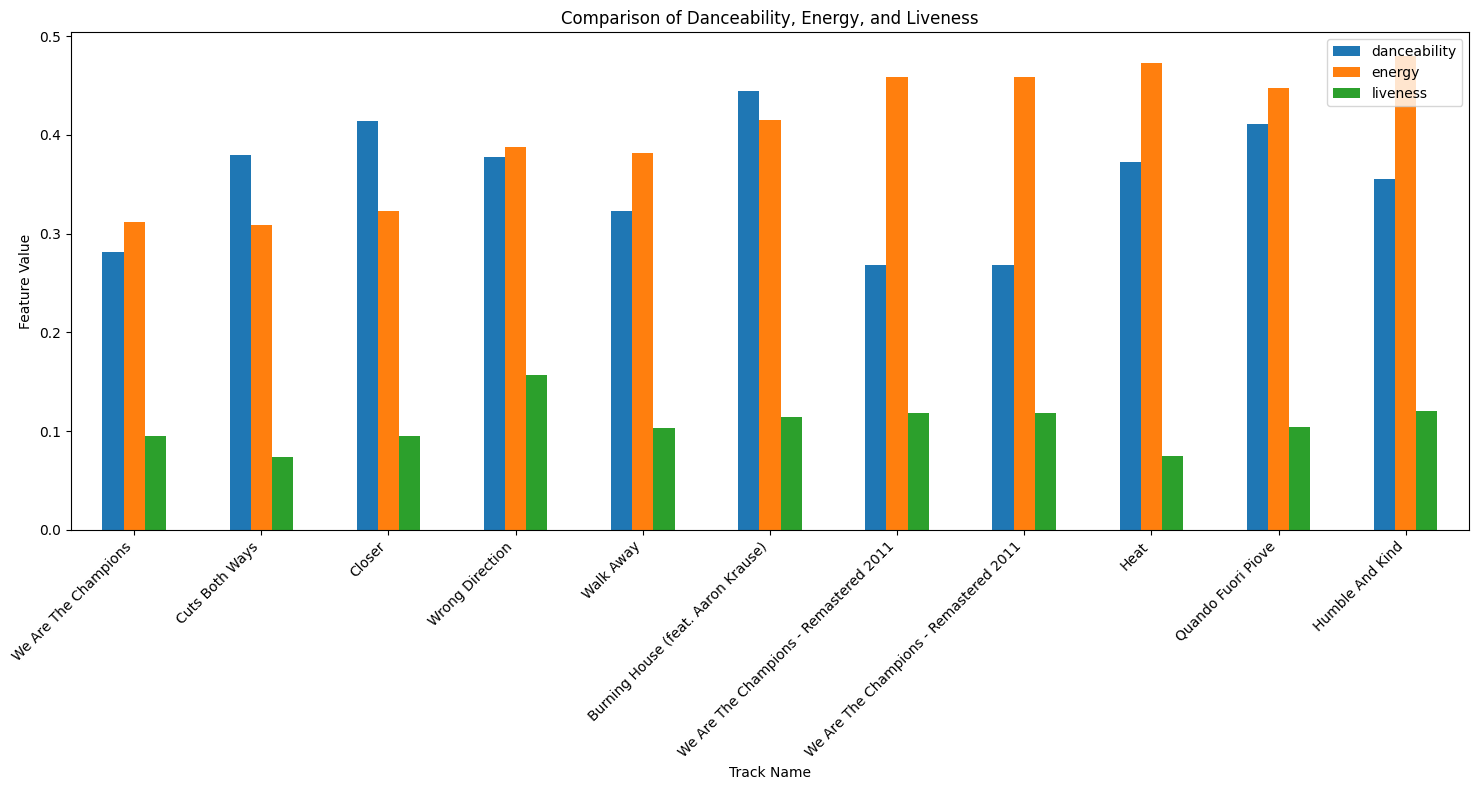

In [131]:
visualize_features(track_name, track_artist, df, recommended_tracks)

## Calculate Precision Call

In [137]:
def calculate_precision_recall(recommended_tracks, relevant_tracks):
    recommended_set = set(recommended_tracks['track_name'])
    relevant_set = set(relevant_tracks['track_name'])
    
    true_positives = len(recommended_set & relevant_set)
    false_positives = len(recommended_set - relevant_set)
    false_negatives = len(relevant_set - recommended_set)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall

In [138]:
relevant_tracks = df[(df['track_artist'] == track_artist) | (df['playlist_genre'] == 'Latin')]  # Define relevant tracks
precision, recall = calculate_precision_recall(recommended_tracks, relevant_tracks)
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.5555555555555556
Recall: 0.0011499540018399263
